In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
from datetime import datetime
from collections import deque
from sklearn import preprocessing 
from sklearn.preprocessing import MinMaxScaler 
import math
import time
from datetime import date
import random
import matplotlib. pyplot as plt
from sklearn.decomposition import PCA
from math import sqrt
from sklearn.metrics import mean_squared_error

In [18]:
train_data = pd.read_csv("train.csv", sep = ",")
train_data = pd.DataFrame(train_data, copy = 1)
test_data = pd.read_csv("test.csv", sep = ",")
test = test_data.copy()
test_data = pd.DataFrame(test_data, copy = 1)

In [21]:
train_data.drop(train_data[train_data.trip_duration < 20].index, inplace=True)


In [22]:
train_data['pickup_datetime'] = pd.to_datetime(train_data.pickup_datetime) # Pickups
# data['dropoff_datetime'] = pd.to_datetime(data.dropoff_datetime) # Drop-offs
train_data['pickup_date'] = train_data['pickup_datetime'].dt.date # Extract date
train_data['pickup_time'] = train_data['pickup_datetime'].dt.time # Extract time
train_data['pickup_hour'] = train_data['pickup_datetime'].dt.hour # Extract hour
train_data['pickup_weekday'] = train_data['pickup_datetime'].dt.dayofweek # Extract day of week
# train_data.drop(['pickup_datetime'], axis = 1, inplace = True)
train_data.drop(['dropoff_datetime'], axis = 1, inplace = True)
train_data.drop(['id'], axis = 1, inplace = True)
train_data.drop(['vendor_id'], axis = 1, inplace = True)

train_data['catégorie'] = train_data['pickup_datetime'].apply(lambda x: "%d/%d" % (x.dayofweek, x.hour))
valeurs = train_data.groupby(["catégorie"]).size()
valeurs = valeurs[(train_data["catégorie"])]
train_data['densité'] = valeurs[(train_data["catégorie"])].values
train_data.drop(['catégorie'], axis = 1, inplace = True)

test_data['pickup_datetime'] = pd.to_datetime(test_data.pickup_datetime)
test_data['pickup_date'] = test_data['pickup_datetime'].dt.date # Extract date
test_data['pickup_time'] = test_data['pickup_datetime'].dt.time # Extract time
test_data['pickup_hour'] = test_data['pickup_datetime'].dt.hour # Extract hour
test_data['pickup_weekday'] = test_data['pickup_datetime'].dt.dayofweek # Extract day of week
# test_data.drop(['pickup_datetime'], axis = 1, inplace = True)

test_data['catégorie'] = test_data['pickup_datetime'].apply(lambda x: "%d/%d" % (x.dayofweek, x.hour))
valeurs = test_data.groupby(["catégorie"]).size()
valeurs = valeurs[(test_data["catégorie"])]
test_data['densité'] = valeurs[(test_data["catégorie"])].values
test_data.drop(['catégorie'], axis = 1, inplace = True)

# test_data.drop(['dropoff_datetime'], axis = 1, inplace = True)
test_data.drop(['id'], axis = 1, inplace = True)
test_data.drop(['vendor_id'], axis = 1, inplace = True)

In [23]:
# fonction pour calculer les distances à vol d'oiseau

def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

# les distances pour Manhattan peuvent être assimiliées à des déplacements simples (on utilise la distance de Manhattan)
def manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b
# train_data.loc[:, 'distance_haversine'] = haversine_array(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)

train_data.loc[:, 'distance_manhattan'] = manhattan_distance(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
test_data.loc[:, 'distance_manhattan'] = manhattan_distance(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)

In [25]:
train_data.loc[:, 'distance_haversine'] = haversine_array(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
test_data.loc[:, 'distance_haversine'] = haversine_array(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)


train_data.loc[:, 'avg_speed_h'] = 1000 * train_data['distance_haversine'] / train_data['trip_duration']
train_data.loc[:, 'avg_speed_m'] = 1000 * train_data['distance_manhattan'] / train_data['trip_duration']

In [26]:
train_data.drop(['pickup_hour'], axis = 1, inplace = True)
train_data.drop(['pickup_weekday'], axis = 1, inplace = True)
test_data.drop(['pickup_hour'], axis = 1, inplace = True)
test_data.drop(['pickup_weekday'], axis = 1, inplace = True)

In [27]:
# coords = np.vstack((train_data[['pickup_latitude', 'pickup_longitude']].values,
#                     train_data[['dropoff_latitude', 'dropoff_longitude']].values
# #                     ,test[['pickup_latitude', 'pickup_longitude']].values,
# #                     test[['dropoff_latitude', 'dropoff_longitude']].values
#                    ))

# pca = PCA().fit(coords)

# pca

In [28]:
train_data.drop(['store_and_fwd_flag'], axis = 1, inplace = True)
train_data.drop(['pickup_date'], axis = 1, inplace = True)
train_data.drop(['pickup_time'], axis = 1, inplace = True)
train_data.drop(['pickup_datetime'], axis = 1, inplace = True)
train_data_tree_X = train_data[['distance_haversine','avg_speed_h', 'avg_speed_m','passenger_count', 'distance_manhattan', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'densité']]
train_data_tree_y = train_data['trip_duration']


# test_data.drop(['pickup_longitude'], axis = 1, inplace = True)
# test_data.drop(['pickup_latitude'], axis = 1, inplace = True)
# test_data.drop(['dropoff_longitude'], axis = 1, inplace = True)
# test_data.drop(['dropoff_latitude'], axis = 1, inplace = True)
test_data.drop(['store_and_fwd_flag'], axis = 1, inplace = True)
test_data.drop(['pickup_date'], axis = 1, inplace = True)
test_data.drop(['pickup_time'], axis = 1, inplace = True)
test_data.drop(['pickup_datetime'], axis = 1, inplace = True)
test_data_tree_X = test_data[['distance_haversine','avg_speed_h', 'avg_speed_m','passenger_count', 'distance_manhattan', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'densité']]
# test_data_tree_y = test_data['trip_duration']

KeyError: "['avg_speed_m', 'avg_speed_h'] not in index"

In [ ]:
train_data_tree_X

In [ ]:
# As with other classifiers, DecisionTreeClassifier takes as input two arrays: an array X, sparse or dense, of size [n_samples, n_features] holding the training samples, and an array Y of integer values, size [n_samples], holding the class labels for the training samples:
from sklearn import tree
X=train_data_tree_X
X_test = test_data_tree_X
y=train_data_tree_y

reg = tree.DecisionTreeRegressor(max_leaf_nodes=50000)
reg = reg.fit(X,y)
y_train_predict_tree=reg.predict(X)

print("La RMSE de l'arbre de régression",sqrt(mean_squared_error(y, y_train_predict_tree)))

#from sklearn.model_selection import cross_validate


#X1, X2, y1, y2 = train_test_split(X, y, random_state=6)




#depth = []
#for i in range(1,2):
#    clf = tree.DecisionTreeRegressor(max_depth=90000+i*1000)
#    clf = clf.fit(X1,y1)
#    print(90000+i*1000," ",sqrt(mean_squared_error(clf.predict(X2), y2)))
#    depth.append((90000+i*1000,sqrt(mean_squared_error(clf.predict(X2), y2))))
#print (depth)



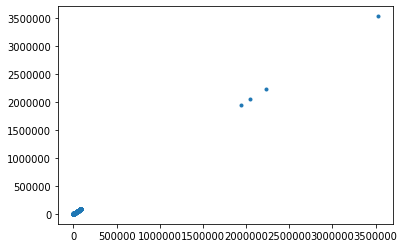

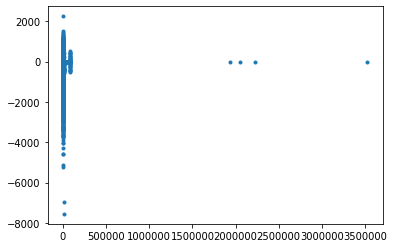

In [29]:
mpl.rcParams['agg.path.chunksize'] = 10000
plt.plot(y_train_predict_tree,y,'.')
plt.show()
plt.plot(y,y_train_predict_tree-y,'.')
plt.show()

In [30]:
y_test_predict_tree=reg.predict(X_test)

In [31]:
my_submission = pd.DataFrame({'id': test.id, 'trip_duration': y_test_predict_tree})
my_submission.to_csv('submission_tree.csv', index=False)